## Dog Breed Identifier

From Kaggle: https://www.kaggle.com/c/dog-breed-identification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import Libraries

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dog-breed/"
sz=224
# !ls data/dog-breed

In [4]:
import pandas as pd

In [5]:
labels=pd.read_csv(f'{PATH}labels.csv')

In [6]:
# print(labels)

In [6]:
import random
val_idx=random.sample(range(len(labels)), 2000)

# Create the Model as ResNet

In [7]:
arch = resnet34
bs=64
# ?ImageClassifierData.from_csv

In [8]:
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', val_idxs= val_idx, suffix='.jpg', tfms=tfms_from_model(arch, sz), bs=bs) 

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.1, 2)

A Jupyter Widget

[ 0.       5.03465  4.83528  0.01025]                       
[ 1.       4.71324  4.90454  0.00977]                       



In [10]:
log_preds = learn.predict()
# log_preds.shape
# data.classes

In [11]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
# probs = np.exp(log_preds[:,1])        # pr(dog)
# probs

In [13]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [14]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [15]:
import PIL

In [16]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [17]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [preds[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


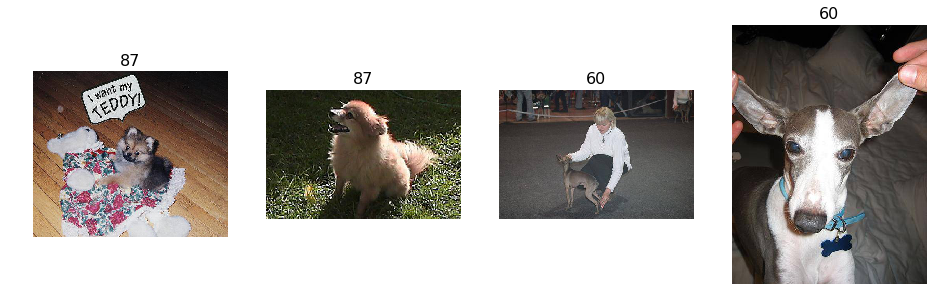

In [18]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


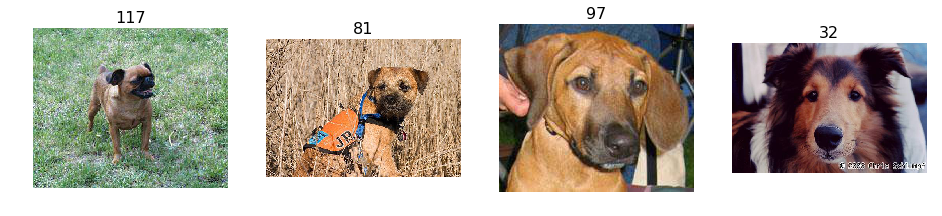

In [19]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

# Choosing Learning Rate

In [20]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [21]:
lrf=learn.lr_find()

A Jupyter Widget

 60%|██████    | 78/129 [00:00<00:00, 96.78it/s, loss=33.9] 


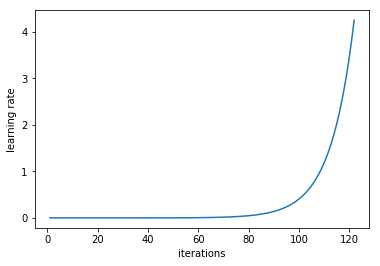

In [22]:
learn.sched.plot_lr()

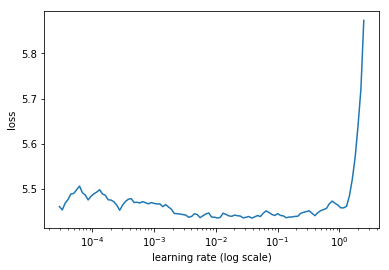

In [23]:
learn.sched.plot()

# Improving the Model

Data Augumentation

In [12]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# ?tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [13]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4, val_idxs= val_idx, suffix='.jpg', tfms=tfms, bs=bs)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [26]:
ims = np.stack([get_augs() for i in range(6)])

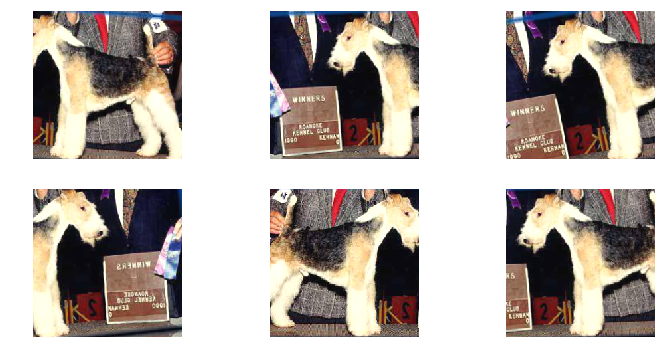

In [27]:
plots(ims, rows=2)

In [14]:
# arch=rexnext50
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4, val_idxs= val_idx, suffix='.jpg', tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [15]:
learn.fit(1e-3, 1)

A Jupyter Widget

[ 0.       5.3866   4.99021  0.00684]                       



In [19]:
learn.precompute=False

In [31]:
learn.fit(1e-0, 2, cycle_len=1)

A Jupyter Widget

[  0.       26.19139   7.59438   0.70459]                   
[    1.       1494.05057   452.16913     0.70166]               



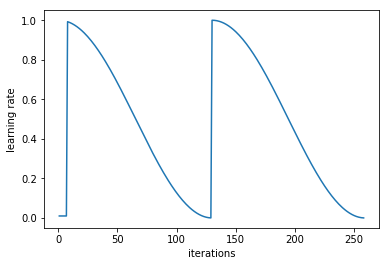

In [33]:
learn.sched.plot_lr()

Fine-tuning and differential learning rate annealing

In [20]:
learn.unfreeze()

In [21]:
lr=np.array([1e-3,1e-2,1e-1])

In [22]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       1.61268  0.90014  0.73193]                       
[ 1.       1.46444  1.0129   0.69385]                       
[ 2.       0.77565  0.75931  0.7832 ]                        
[ 3.       1.06439  1.19718  0.6709 ]                       
[ 4.       0.78154  0.90853  0.74121]                        
[ 5.       0.42017  0.76656  0.79004]                        
[ 6.       0.2874   0.75222  0.79004]                        



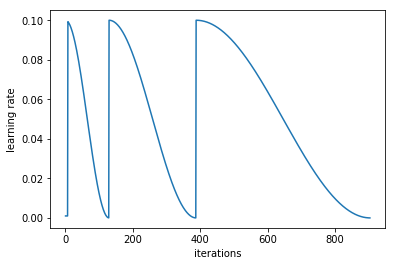

In [23]:
learn.sched.plot_lr()

# Analyse the result

In [71]:
# preds = np.argmax(probs, axis=1)
# probs = probs[:,1]
# preds
len(probs)

120

In [46]:
?data

In [24]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(log_preds, axis=1) 

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[13  0  0 ...,  0  0  0]
 [ 0 24  0 ...,  0  0  0]
 [ 0  0 17 ...,  1  0  0]
 ..., 
 [ 0  0  0 ..., 13  0  0]
 [ 0  0  0 ...,  0 14  0]
 [ 0  0  0 ...,  0  0 12]]


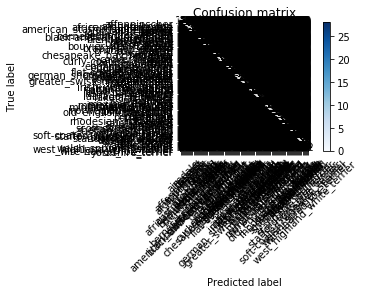

In [26]:
plot_confusion_matrix(cm, data.classes)

In [27]:
sum(cm[i][i] for i in range(len(cm)))

1613

In [75]:
sum(sum(cm))

2000

##### Get the result

In [28]:
test_log_preds,test_y = learn.TTA(is_test=True)

In [29]:
 test_pred_results = np.exp(test_log_preds)

In [37]:
len(test_pred_results)

10357

In [54]:
f= open (f'{PATH}out.csv', 'w')

list = []
row=''
row = "id,"
for head in data.classes:
    row+=head
    row+=","
row = row[:-1]
row+="\n"
f.write(row)
for i in range(len(data.test_dl.dataset.fnames)):
    row = str(data.test_dl.dataset.fnames[i]).split("/")[1]
    row=row.split(".")[0]
    row+=","
    for head in test_pred_results[i]:
        row += str(head)
        row += ","
    row = row[:-1]
    row += "\n"
    f.write(row)